In [4]:
import os
import random
import numpy as np 
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import cv2 

In [6]:
### DEFINE SOME PARAMETERS ###

base_path = "/home/someshwar/Documents/try/archive/"
SHAPE = (224,224,3)
batch_size = 256

In [7]:
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

In [8]:
x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation="softmax")(x)
model = Model(vgg_conv.input, x)
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])

In [9]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    
def get_model():
    
    set_seed(33)
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = SHAPE)

    for layer in vgg.layers[:-8]:
        layer.trainable = False

    x = vgg.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation="softmax")(x)

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model

In [10]:
### INITIALIZE GENERATORS ###

train_datagen = train_datagen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)

test_datagen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)

In [11]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            base_path,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'training',
            seed = 33
)

test_generator = test_datagen.flow_from_directory(
            base_path,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'validation',
            seed = 33
)

Found 28000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


In [12]:
### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)

label_test.shape

(12000,)

In [ ]:
model = get_model()
model.fit(train_generator, steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=8)

In [ ]:
### PERFORMANCE ON TEST DATA ###

print(classification_report(label_test, np.argmax(model.predict(test_generator),axis=1)))

In [3]:
def plot_activation(img):
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = Model(model.input, model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    act_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), class_weights).reshape(img.shape[0],img.shape[1])
    plt.imshow(img.astype('float32').reshape(img.shape[0], img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')

1/1 [==============================] - 0s 208ms/step


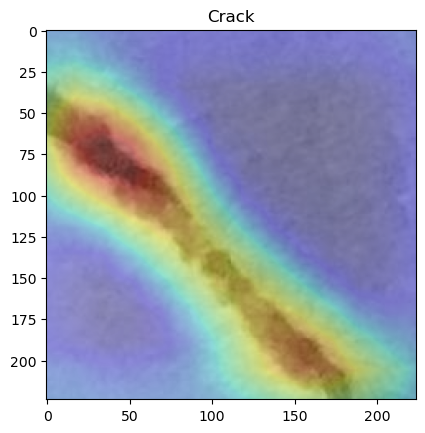

In [14]:
### PLOT HEATMAPS ON TEST DATA ###
plot_activation(X[0])

In [21]:
def generate_mask(img, model):
    pred = model.predict(img[np.newaxis, :, :, :])
    pred_class = np.argmax(pred)
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = Model(model.input, model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis, :, :, :])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0] / conv_output.shape[0])
    w = int(img.shape[1] / conv_output.shape[1])
    act_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0] * img.shape[1], 512)), class_weights).reshape(img.shape[0], img.shape[1])

    return out

def generate_mask_labels(img, model, threshold=0.5):
    mask = generate_mask(img, model)
    labels = np.zeros_like(mask)
    labels[mask >= threshold] = 1

    return labels

def plot_activation(img, model, threshold=0.5):
    labels = generate_mask_labels(img, model, threshold)

    plt.imshow(img.astype('float32').reshape(img.shape[0], img.shape[1], 3))
    plt.imshow(labels, cmap='jet', alpha=0.35)
    plt.title('Crack' if np.max(labels) > 0 else 'No Crack')
    plt.show()

In [13]:
model = tf.keras.models.load_model("/home/someshwar/Documents/crack_model.h5")

In [23]:
masked = generate_mask_labels(X[0], model, threshold=0.5)

1/1 [==============================] - 0s 205ms/step


In [40]:
labels = generate_mask_labels(X[0], model, threshold=0.5)
cv2.imshow(X[0].astype('float32').reshape(X[0].shape[0], X[0].shape[1], 3))
cv2.imshow(labels, cmap='jet', alpha=0.35)

1/1 [==============================] - 0s 254ms/step


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import json
from tensorflow.keras.models import Model

def generate_mask(img, model):
    pred = model.predict(img[np.newaxis, :, :, :])
    pred_class = np.argmax(pred)
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = Model(model.input, model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis, :, :, :])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0] / conv_output.shape[0])
    w = int(img.shape[1] / conv_output.shape[1])
    act_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0] * img.shape[1], 512)), class_weights).reshape(img.shape[0], img.shape[1])

    return out

def generate_mask_labels(img, model, threshold):
    mask = generate_mask(img, model)
    labels = np.zeros_like(mask)
    labels[mask >= threshold] = 1

    return labels

def save_labels_to_labelme(labels, img_shape, file_path):
    labelme_data = {
        "version": "4.5.9",
        "flags": {},
        "shapes": [],
        "imagePath": "",
        "imageData": None,
        "imageHeight": img_shape[0],
        "imageWidth": img_shape[1]
    }

    for label_val in np.unique(labels):
        if label_val == 0:
            continue
        mask = labels == label_val
        mask_points = np.transpose(np.nonzero(mask))
        mask_points = mask_points.tolist()
        shape_data = {
            "label": "object",
            "points": mask_points,
            "group_id": None,
            "shape_type": "polygon",
            "flags": {}
        }
        labelme_data["shapes"].append(shape_data)

    with open(file_path, 'w') as f:
        json.dump(labelme_data, f, indent=4)

def plot_activation(img, model, threshold):
    labels = generate_mask_labels(img, model, threshold)

    plt.imshow(img.astype('float32').reshape(img.shape[0], img.shape[1], 3))
    plt.imshow(labels, cmap='jet', alpha=0.35)
    plt.title('Crack' if np.max(labels) > 0 else 'No Crack')
    plt.show()

    # Save labels to LabelMe JSON file
    save_labels_to_labelme(labels, img.shape[:2], 'mask_labels.json')

1/1 [==============================] - 0s 235ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


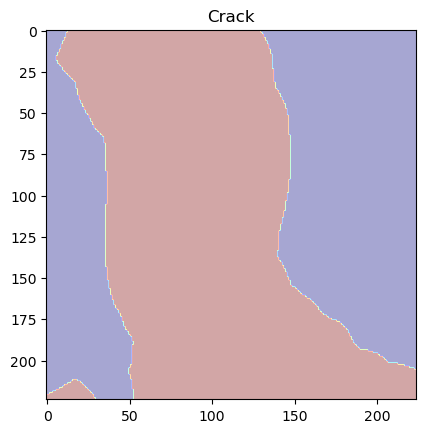

In [76]:
image = cv2.imread("/home/someshwar/Documents/trial/00003.jpg")
resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)#plt.imshow(img)
#plt.imshow(resized_image)
plot_activation(resized_image, model, 1.2)

1/1 [==============================] - 0s 230ms/step


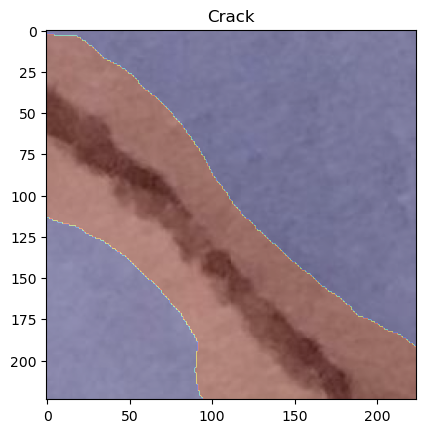

In [86]:
plot_activation(X[0], model, threshold=0.5)

1/1 [==============================] - 0s 199ms/step


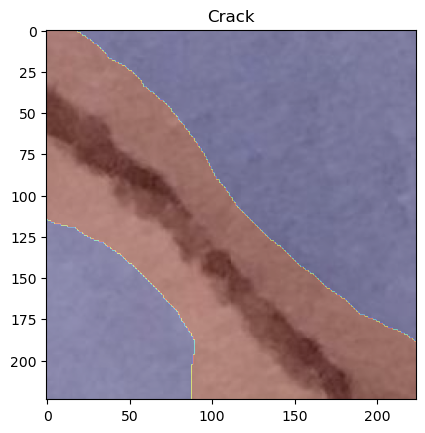

In [80]:
plot_activation(X[0], model, 0.1)

In [2]:
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

2023-06-19 16:34:52.951591: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 16:34:53.039653: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 16:34:53.040489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 16:34:54.432654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
model = Sequential()
# encoder network
model.add(Conv2D(30, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
#decoder network
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(30, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # output layer
model.compile(optimizer= 'adam', loss = 'binary_crossentropy')
model.summary()

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

In [8]:
import torch
import torchvision
model = torchvision.models.vgg16(pretrained=False)
model = torch.load('/home/someshwar/model.pth', map_location=torch.device('cpu'))
model

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

# Create a new Keras model
keras_model = Sequential()
keras_model.add(Dense(64, input_shape=(224, 224,), activation='relu'))
keras_model.add(Dense(10, activation='softmax'))

# Copy the weights from the PyTorch model to the Keras model
for i, layer in enumerate(keras_model.layers):
    if i == 0:
        continue  # Skip the first layer as it's the input layer
    layer.set_weights([model[f'features.{i-1}.weight'].numpy().T, model[f'features.{i-1}.bias'].numpy()])

# Save the Keras model in .h5 format
keras_model.save('model.h5')

In [17]:
model.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [ ]:
print(model.state_dict().keys())

In [ ]:
model = vgg16()
saved_state_dict = torch.load('/home/someshwar/model.pth')
model.load_state_dict(saved_state_dict)